# Introduction
In this jupyter notebook, we present an implementation of the Maximum-Entropy based Stochastic
and Symbolic densitY estimation (MESSY) paper published in TMLR:
https://openreview.net/pdf?id=Y2ru0LuQeS

Given samples $X$ of an unknown density $f$, MESSY finds the maximum entropy distribution of the form

$\hat f( x) = Z^{-1}\exp\big( \lambda \cdot H( x) \big) $

where $Z =\int \exp(  \lambda \cdot  H( x)  ) d  x$ is the normalization constant. We note that $\hat f$ is the extremum of the objective functional which maximizes Shannon entropy with constraint on moments $\mu=\mathbb{E}[H(X)]$, i.e.

$ \mathcal{C} [\mathcal{F}(x)]:=\int \mathcal{F}( x) \log(\mathcal{F}(x)) d x - \sum_{i=1}^{N_b} \lambda_i  \left(\int H_i( x) \mathcal{F}( x) d  x-\mu_i( x)\right)~$.

Below, we load the necessary libraries and provide an impelmentation of the MESSY algorithm. Here, $H$ denotes either standard polynomial basis functions, or well-conditioning symbolic functions found through regression.


In [1]:
import numpy as np
from numpy.linalg import norm
import sympy as sp
from sympy import oo, zoo, nan
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.linalg import solve, LinAlgError
from scipy.special import rel_entr
import pandas as pd
from sklearn.neighbors import KernelDensity
import statistics as stat
from collections import defaultdict
import warnings
import random
import time
import sys

def np_lambdify(varname, func):
    lamb = sp.lambdify(varname, func, modules=['numpy'])
    if func.is_constant():
        return lambda t: np.full_like(t, lamb(t))
    else:
        return lambda t: lamb(np.array(t))

def moments(h, z, w=None):
  return np.array([np.average(hh(z), weights=w) for hh in h])

def KL_Divergence(true_dist, pred_dist, xmin, xmax):
  xx = np.linspace(xmin,xmax,10000)
  p, q = true_dist(xx), pred_dist(xx)
  p = np.asarray(p, dtype=np.float)
  q = np.asarray(q, dtype=np.float)
  return np.sum(np.where(q > 1e-10, p * np.log(p / q), 0))#/len(p);

def random_even_expr(self, depth=2, even=False):
  if depth == 0 or random.random() < 0.3:
    return x**2 if even else random.choice(unary_functions)(x)
  if random.random() < 0.7:
    op = random.choice(binary_operators)
    left = random_even_expr(depth - 1, even)
    right = random_even_expr(depth - 1, even)
    return op(left, right)
  else:
    return random.choice(unary_functions)(random_even_expr(depth - 1, even))

def random_tree(depth=2, even=False, xmax = 10):
  done = False
  while not done:
    expr = random_even_expr(depth,even)
    if sp.lambdify(x, expr, "numpy")(xmax) < xmax**highest_order:
      done = True
  return expr

def get_unique(H_s):
  unique_expr_set = set()
  for expr in H_s:
    expr_hashable = sp.sympify(expr).simplify().as_expr()
    unique_expr_set.add(expr_hashable)
  return list(unique_expr_set)

def is_even(func):
  func_neg_var = func.subs(x, -x)
  return func.equals(func_neg_var)

def make_fastest_even(H_s, xmax = 10):
  x = sp.symbols('x', real=True)
  H = [np.vectorize(sp.lambdify(x, h_s, "numpy")) for h_s in H_s]
  H_rates = [h(xmax) for h in H]
  idx_fastest, max_rate = np.argmax(H_rates), np.max(H_rates)
  H_s[idx_fastest], H_s[-1] = H_s[-1], H_s[idx_fastest]
  if not is_even(H_s[-1]):
    power, done = 2, False
    while not done and power <= highest_order:
      new_basis_s = x**power
      new_basis  = np.vectorize(sp.lambdify(x, new_basis_s, "numpy"))
      if new_basis(xmax) >= max_rate:
        done = True
      power += 2
    H_s[-1], H[-1] = new_basis_s, new_basis
  return H_s

def create_basis(n_bases=6,tree_depth=2):
  x = sp.symbols('x', real=True)
  done = False
  while not done:
    H_s = [random_tree(depth=tree_depth, even=random.choice([True, False])) for _ in range(n_bases)]
    H_s = make_fastest_even(H_s)
    if len(get_unique(H_s)) == n_bases:
      done = True
  return H_s

def Hess(X, dh):
  Nm = len(dh)
  L = np.zeros((Nm, Nm))
  for i in range(Nm):
    for j in range(Nm):
      L[i, j] = np.mean(dh[i](X) * dh[j](X))
  return L

def orthogonalize_basis_MGS(X, h):
  ## Modified Gram-Schmidt to orthogonalize basis function to get <H_i H_j f(X)>=delta_{ij}
  p = h
  Nm = len(p)
  for i in range(0, Nm):
    p[i] = p[i] / np.mean(sp.lambdify(x, p[i],'numpy')(X) ** 2) ** 0.5
    for j in range(i+1, Nm):
      project = np.mean(sp.lambdify(x,p[j],'numpy')(X)*sp.lambdify(x,p[i],'numpy')(X))
      p[j] = p[j] - project*p[i]
  return p

# Find the index of the closest bin center and return the probability density at that bin
def pdf_hist(x, hist, bin_edges, bin_centers):
  if isinstance(x, float):
    if x < bin_edges[0] or x > bin_edges[-1]:
      return 0.
    # Find the index of the closest bin center
    idx = np.argmin(np.abs(bin_centers - x))

    # Return the probability density at that bin
    return hist[idx]
  else:
    return np.array([pdf_hist(item, hist, bin_edges, bin_centers) for item in x])

def mgf_statio(X_, ZZ, H_lambdify, dim, tol, targ_grad=None, weights=None, max_steps=1000):
  step = 0
  conv = False

  momX = moments(H_lambdify, X_)#, dim)
  samples_ = np.array([H_lambdify[i](ZZ) for i in range(0, dim)]) - momX[:,None]

  if targ_grad is None:
    targ_grad = np.zeros(dim)

  if weights is None:# or sum(weights) == 0:
    weights = np.ones_like(ZZ)

  # initial lambda and corresponding likelihood ratios
  lam, lrs = np.zeros(dim), weights

  np.seterr(over='raise')
  lams_hist = [lam]
  grad_ = []
  grad_hist = []
  cond_hist = []
  while True:
    # gradient of MGF
    if sum(lrs) == 0:
      lrs = np.ones_like(ZZ)
      lam *= 0
      break
    grad = np.average(samples_, weights=lrs , axis=1) - targ_grad
    grad_hist.append(np.linalg.norm(grad))
    grad_.append(np.average(samples_, weights=lrs , axis=1) - targ_grad)
    if all(np.absolute(grad) < tol) or step == max_steps:
      if step < max_steps:
        conv = True
      break
    # hessian of MGF
    hess = np.zeros((dim, dim))
    for k, sample in enumerate(samples_):
      hess[k, k:] = np.average(sample * samples_[k:], weights=lrs , axis=1)
      hess[k:, k] = hess[k, k:]
    # print("cond hess: ", np.linalg.cond(hess))
    cond_hist.append(np.linalg.cond(hess))
    # Newton step
    try:
      new_lam = lam - solve(hess, grad)
    except (LinAlgError, ValueError, OverflowError, FloatingPointError):
      print('Matching stopped: singular hessian')
      lam *= 0.
      lrs = np.ones_like(lrs)
      break
    # likelihood ratios corresponding
    # to new Lagrange multipliers
    if weights is None:
      weights = np.ones_like(ZZ)
    try:
      lrs  = np.exp(np.dot(new_lam, samples_) + np.log(weights))
    except (LinAlgError, ValueError, OverflowError, FloatingPointError):
      print('Matching stopped: too big likelihood ratios')
      lam *= 0.
      lrs = np.ones_like(lrs)
      break

    # if no exceptions, accept new_lam
    lam = new_lam
    lams_hist.append(lam)
    step += 1

  return lam, lrs, conv

def check_exponent_overflow(expr, samples):#, test_values=[np.min(Y), np.max(Y)]):
  test_values = [np.min(samples), np.max(samples), np.min(samples)-.5, np.max(samples)+.5]#, np.min(samples)-0.5, np.min(samples)+0.5]
  for val in test_values:
    try:
      result = expr.subs(x, val).evalf() # for discontinous
      if abs(result) < 10**6: # for discontinous
        return True
    except (LinAlgError, ValueError, OverflowError, FloatingPointError):
      return True
  return False

def vectorized_piecewise_evaluator(expr, input_array):
  result = np.zeros_like(input_array, dtype=float)
  for e, c in expr.args:
    if c == True:
      continue
    cond = sp.lambdify(x, c, 'numpy')(input_array)
    if isinstance(cond,np.ndarray):
      result[cond==True] = sp.lambdify(x, e, 'numpy')(input_array[cond==True])
    else:
      if cond == True:
        result = sp.lambdify(x, e, 'numpy')(input_array)
  return result

def weighted_sum_piecewise_evaluator(weight_list, expr_list, input_array):
  res = np.zeros_like(input_array)
  for i,expr in enumerate(expr_list):
    res += weight_list[i]*vectorized_piecewise_evaluator(expr, input_array)
  return res

def Multi_Level_SDE(X, N_iters=10, threshold_sample=1e-1, poly_bases=False, verbose = False, piecewise=False):
  flag = False
  while not flag:
    Nt = 20
    dt = 1e-20
    tau = 100. # 1e20
    list_pdf, list_mass = [], []
    w = np.ones_like(X, dtype=int)
    Y = X.copy()
    N_t = len(X)
    for k in range(N_iters):
      if verbose:
        print('Level:', k)

      Y = np.array([j for i,j in enumerate(Y) if w[i] == 1])
      Y0 = Y.copy()
      w = np.ones_like(Y, dtype=int)

      done = False
      while not done:
        while True:
          ## construct basis function for the data
          if not poly_bases:
            OKBasis = False
            while OKBasis is not True:
              H = create_basis(random.randint(nb_l,nb_u), tree_depth)
              H = list(set(H))
              dH = [sp.diff(h, x) for h in H]
              dH_new  = [sp.lambdify(x, dh, "numpy") for dh in dH]
              L = Hess(Y, dH_new)
              print("cond(L)", np.linalg.cond(L))
              if np.linalg.cond(L) < 1e6:
                OKBasis = True
          else:
            H = [x**i for i in range(1, poly_order + 1)]
          print('generate a basis')
          dH = [sp.diff(h, x) for h in H]
          dH = orthogonalize_basis_MGS(Y, dH)
          H  = [sp.integrate(dh, x) for dh in dH]

          dH_new  = [np_lambdify(x, dh) for dh in dH]

          lam   = np.zeros_like(dH_new)

          lam_sum = np.zeros(len(lam))
          L = Hess(Y, dH_new)
          print("cond(L)", np.linalg.cond(L), " after orthogonalization")
          break
          try:
            if np.linalg.cond(L) < 10000.:
              break
          except (LinAlgError, ValueError, OverflowError, FloatingPointError):
            print('large condition number')
            break
        print('found a good basis')
        H_new   = [sp.lambdify(x, h, "numpy") for h in H]
        d2H     = [sp.diff(dh, x) for dh in dH]
        d2H_new = [sp.lambdify(x, d2h, "numpy") for d2h in d2H]

        momX  = moments(H_new, X)#, n=Nm)
        momY0 = moments(H_new, Y)#, n=Nm)

        invL = np.linalg.inv(L)

        exponent = sum([ll * hh for ll,hh in zip(lam,H)])
        for i in range(Nt):

          momY = moments(H_new, Y)#, n=Nm)
          dmom = momX - momY
          d2h = np.array([np.average(d2h_new(Y)) for d2h_new in d2H_new])

          b = -(dmom) / tau - d2h

          lam = invL @ b

          lam_sum += lam
          for i in range(10):
            A = np.dot(lam, np.array([dh_new(Y) for dh_new in dH_new]))
            dW = np.random.normal(0., 1., len(Y))
            Y = Y + A * dt + (2. * dt) ** 0.5 * dW
            momY = moments(H_new, Y)#, n=Nm)
            dmom = momX - momY
          exponent = sum([ll * hh for ll, hh in zip(lam,H)]) #sum([lam[i] * H[i] for i in range(Nm)])
        lam = lam_sum / Nt
        Y = Y0
        exponent = sum([ll * hh for ll, hh in zip(lam,H)])
        f = sp.exp(exponent)
        print(f)
        #if not (f.has(oo, -oo, zoo, nan) or check_exponent_overflow(f,X)) or poly_bases:
        #  print('done')
        #  done = True
        done = True
        f_lambdify = sp.lambdify(x, f,'numpy')
      try:
        Z = integrate.quad(f_lambdify, np.min(Y), np.max(Y))[0]
        #Z = MC_moments_from_pdf(f_lambdify, [lambda x: x**0], np.random.uniform(np.min(Y),np.max(Y),10000))[0]
      except (LinAlgError, ValueError, OverflowError, FloatingPointError):
         print('Z quad overflow')
         break
      f_g = lambda x: f_lambdify(x) / Z

      # Compute histogram and bin edges
      hist, bin_edges = np.histogram(Y, bins=100, density=True)

      # Compute bin centers
      bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

      for i, y in enumerate(Y):
        w[i] = 0 if np.random.rand() < f_g(y)/pdf_hist(y, hist, bin_edges, bin_centers) else 1

      if sum(list_mass) > 1.-threshold_sample or k == N_iters-1:# or sum(w==0) / N_t < threshold_sample:
        w = np.zeros_like(Y)

      mass = sum(w==0) / N_t

      if mass < threshold_sample:
        f = sp.exp(-(x)**2/(2*np.var(Y)))#/(2*sp.pi*np.var(Y))**0.5 -np.mean(Y)
        f_lambdify = sp.lambdify(x, f,'numpy')
        f_g = lambda x: f_lambdify(x) / (2*np.pi*np.var(Y))**0.5
        for i, y in enumerate(Y):
          w[i] = 0 if np.random.rand() < f_g(y)/hist_pdf(y, hist, bin_edges, bin_centers) else 1
        mass = sum(w==0) / N_t
      # print(mass)
      list_mass.append(mass)

      Y_loc = np.array([j for i,j in enumerate(Y) if w[i] == 0])

      #Z = MC_moments_from_pdf(f_lambdify, [lambda x: x**0], np.random.uniform(np.min(Y_loc),np.max(Y_loc),10000))[0]
      Z = integrate.quad(f_lambdify, np.min(Y_loc), np.max(Y_loc))[0]

      if piecewise:
        list_pdf.append(sp.Piecewise((f/Z, (x>=np.min(Y_loc)) & (x<=np.max(Y_loc))), (0, True)))
      else:
        list_pdf.append(f/Z)

      if sum(list_mass) > 1.-threshold_sample or len(w[w==1])<20 or mass < threshold_sample: # we cannot recover distribution when there are not enough samples
        break
      # print(f/Z)
      # print(mass)
    f_g_s = sum([mass*f for mass,f in zip(list_mass, list_pdf)])

    flag = True
    #if not (f_g_s.has(oo, -oo, zoo, nan) or check_exponent_overflow(f_g_s, Y)) or poly_bases:
    #  print('flag true')
    #  flag = True
    #if not poly_bases and (f_g_s.has(oo, -oo, zoo, nan) or check_exponent_overflow(f_g_s, Y)):
    #  if verbose:
    #    print("\nRepeat!, found inf, nan on pdf values")

  f_g = sp.lambdify(x, f_g_s, 'numpy')

  return f_g, f_g_s, list_mass, list_pdf

def CrossEntropy(X,H,H_new,f_g,f_g_s,Nm_xe,list_mass,list_pdf,poly_bases=False, piecewise=False):
  done = False
  n_m = Nm_xe
  while not done:
    conv = False
    while not conv:
      ZZ = np.random.uniform(np.min(X),np.max(X), 10000)
      try:
        p = f_g(ZZ)
      except (LinAlgError, ValueError, OverflowError, FloatingPointError):
        return f_g, f_g_s, ZZ, None, 1.
      ZZ = np.random.choice(ZZ, size=len(ZZ), p=p/sum(p))
      lam, weights, conv = mgf_statio(X, ZZ, H_new, n_m, tol=1e-14)

    corrector = sp.exp(sum([ll * hh for ll, hh in zip(lam,H)]))
    f_g_s_new = 0
    if piecewise:
      piece_list = []
      for i in range(len(list_mass)):
        piece = sp.Piecewise(*[(expr * corrector, cond) for expr, cond in list_pdf[i].args])
        piece_list.append(piece)
        f_g_s_new += list_mass[i] * piece
    else:
      for i in range(len(list_mass)):
        f_g_s_new += list_mass[i] * list_pdf[i] * corrector

    if (f_g_s_new.has(oo, -oo, zoo, nan) or check_exponent_overflow(f_g_s_new, ZZ)):
      return f_g, f_g_s, ZZ, None, 1.

    if piecewise:
      f_g_s_new_lambdify = lambda x: weighted_sum_piecewise_evaluator(list_mass, piece_list, x)
    else:
      f_g_s_new_lambdify = sp.lambdify(x, f_g_s_new, 'numpy')
    if True: #not poly_bases:
      try:
        # Z = MC_moments_from_pdf(f_g_s_new_lambdify, [lambda x: x**0], np.random.uniform(np.min(X),np.max(X),10000))[0]
        Z = integrate.quad(f_g_s_new_lambdify, np.min(X), np.max(X))[0]
        done = True
      except (LinAlgError, ValueError, OverflowError, FloatingPointError):
        n_m -= 2
        break
    else:
      # Z = MC_moments_from_pdf(f_g_s_new_lambdify, [lambda x: x**0], np.random.uniform(np.min(X),np.max(X),10000))[0]
      Z = integrate.quad(f_g_s_new_lambdify, np.min(X), np.max(X))[0]
      done = True
  f_g_new = lambda x: f_g_s_new_lambdify(x) / Z
  return f_g_new, f_g_s_new, ZZ, weights, corrector

def get_pdf(X, N_iters=5, Nm_xe=2, N_levels=3, threshold_sample=1e-1, verbose=False, piecewise=False):
  min_rel_err, min_rel_err_h = np.inf, np.inf
  dic = {}
  i = 0
  R_low = [x**i for i in range(1, Nm_xe+1)]
  R_low_ = [sp.lambdify(x,r_s,"numpy") for r_s in R_low]
  X_moms_low = moments(R_low_, X)
  while i < N_iters:
    if verbose:
      print('Round:', i, " out of ", N_iters)
    f_g, f_g_s, list_mass, list_pdf = Multi_Level_SDE(X, N_levels, threshold_sample, poly_bases=(i==0), verbose=verbose, piecewise=piecewise)
    print('SDE done, Starting MxED')
    f_g_new, f_g_s_new, samples, weights, corrector = CrossEntropy(X,R_low, R_low_,f_g,f_g_s,Nm_xe,list_mass,list_pdf,poly_bases=(i==0),piecewise=piecewise)
    print('MxED done')
    #if i != 0 and (f_g_s_new.has(oo, -oo, zoo, nan) or check_exponent_overflow(f_g_s_new, X)):
    #  continue
    #print('Passed Checking!')
    mom_low, mom_high = 1, Nm_xe+3

    R_s = [x**i for i in range(mom_low, mom_high)]
    R = [sp.lambdify(x,r_s,"numpy") for r_s in R_s]
    if weights is None: # if cross entropy didn't work out
      ss = np.random.uniform(np.min(X)-np.std(X),np.max(X)+np.std(X), 10000)
      try:
        wghts = f_g_new(ss)/sum(f_g_new(ss))
      except (LinAlgError, ValueError, OverflowError, FloatingPointError):
        continue
    else:
      ss = samples
      wghts = weights

    est_moms = moments(R, ss, w=wghts)
    X_moms = moments(R, X)
    rel_err = np.linalg.norm(est_moms-X_moms)/np.linalg.norm(X_moms)
    dic[i] = [f_g_new, f_g_s_new, rel_err, ss, wghts]
    if rel_err < min_rel_err:
      min_rel_err = rel_err
      best_iter = i
    i+=1
    if verbose:
      print('Done with Round:', i, " out of ", N_iters, "\n")
  if verbose:
    print('best_iter:', best_iter)
  return dic, best_iter


# Example: Bi-modal distribution
First, we generate samples of the target density:

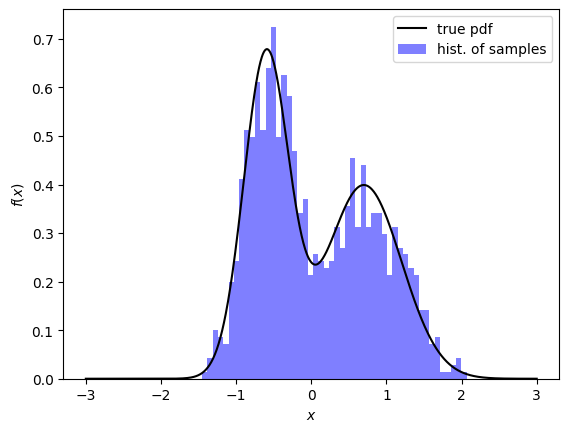

In [2]:
def Gaussian(x,mu,sig):
  return 1.0/(sig*np.sqrt(2.0*np.pi)) * np.exp(-0.5*(x-mu)**2/sig**2)

def bi_mod(x,mu1,mu2,sig1,sig2):
  return 0.5*( Gaussian(x,mu1,sig1) + Gaussian(x,mu2,sig2) )

n_samples = 1000
mu1 = -0.6; mu2=0.7; sig1=0.3; sig2 = 0.5
X = np.concatenate([np.random.normal(mu1,sig1,int(n_samples/2)), np.random.normal(mu2,sig2,n_samples-int(n_samples/2))])
true_pdf = lambda x: bi_mod(x,mu1,mu2,sig1,sig2)

xx = np.linspace(-3, 3, 1000) # for plotting
fig, ax = plt.subplots()
ax.plot(xx, true_pdf(xx), color="black", label = "true pdf")
_ = ax.hist(X, color="blue", label = "hist. of samples", density=True, bins=50, alpha=0.5)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$f(x)$")
ax.legend()
plt.show()

In [3]:
## MESSY
constant_range=(1,3)
def cos_(x):
  integer = random.randint(*constant_range)
  half = integer + random.choice([0, 0.5])
  return sp.cos(sp.Rational(half)*x)
def sin_(x):
  integer = random.randint(*constant_range)
  half = integer + random.choice([0, 0.5])
  return sp.cos(sp.Rational(half)*x)

x = sp.symbols('x', real=True)
highest_order = 2 # highest order term
tree_depth = 2 # depth of the tree expression
poly_order = highest_order # order of polynomial in MESSY-P
pow = [sp.lambdify(x, x**i, "numpy") for i in range(1, highest_order+1)] # Poly. basis functions
binary_operators = [sp.Mul]
unary_functions = [sp.cos, sp.sin] + pow
n_rounds = 10 # number of iterations for the outmost search loop
nm_xe = highest_order # highest order term of the constructed basis
nb_l, nb_u = 2, 6
dic, best_iter = get_pdf(X, N_iters=n_rounds, Nm_xe=nm_xe, N_levels=2, threshold_sample=0.1, verbose = True, piecewise=False)
messy_s_pdf = dic[best_iter][0]

Round: 0  out of  10
Level: 0
generate a basis
cond(L) 1.0000000000000049  after orthogonalization
found a good basis
exp(-0.840536819056225*x**2 + 0.09462414426036*x)
Level: 1
generate a basis
cond(L) 1.000000000000006  after orthogonalization
found a good basis
exp(-0.626871775855955*x**2 - 0.104865421626078*x)
SDE done, Starting MxED
MxED done
Done with Round: 1  out of  10 

Round: 1  out of  10
Level: 0
cond(L) 542.4873211151155
generate a basis
cond(L) 1.0000000000000369  after orthogonalization
found a good basis
exp(-8.1807161046089*x**2 - 2.37230624732017*x*cos(x) + 1.23397815002322*x - 17.0230835270241*cos(x))
Level: 1
cond(L) 18.61401940579809
generate a basis
cond(L) 1.0000000000000027  after orthogonalization
found a good basis
exp(5.27332552867278*cos(x) - 8.43417345981492*cos(sin(x)))
SDE done, Starting MxED
MxED done
Done with Round: 2  out of  10 

Round: 2  out of  10
Level: 0
cond(L) 899.0739739163536
generate a basis
cond(L) 1.0000000000000795  after orthogonalizati

Found MESSY-P:
0.420064425002614*exp(-0.840536819056225*x**2 + 0.09462414426036*x) + 0.104649487146021*exp(-0.626871775855955*x**2 - 0.104865421626078*x)



Found MESSY-S:
0.867232636734791*exp(5.27332552867278*cos(x) - 8.43417345981492*cos(sin(x))) + 8481530.83032242*exp(-8.1807161046089*x**2 - 2.37230624732017*x*cos(x) + 1.23397815002322*x - 17.0230835270241*cos(x))





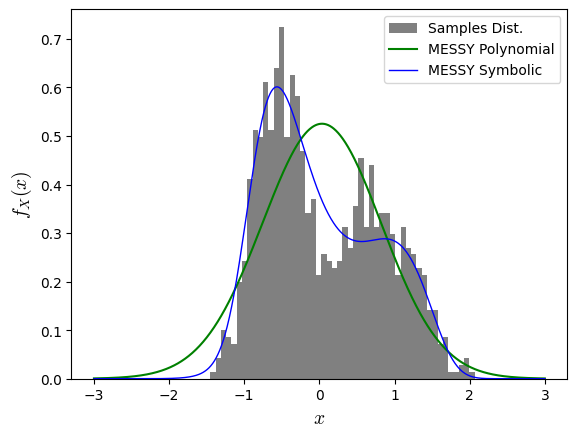

In [5]:
xx = np.linspace(-3, 3, 1000)

print("Found MESSY-P:")
print( dic[0][1] )
print("\n\n")

print("Found MESSY-S:")
print( dic[best_iter][1] )
print("\n\n")

fig, ax = plt.subplots()
plt.rcParams['mathtext.fontset'] = 'cm'
plt.hist(X, bins=50, density=True, color="grey", label = "Samples Dist.")
plt.plot(xx, dic[0][0](xx), linewidth = 1.5, label = "MESSY Polynomial", color = 'green')
plt.plot(xx, dic[best_iter][0](xx), linewidth = 1, label = "MESSY Symbolic", color = 'blue')
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$f_X(x)$", fontsize=14)
plt.legend()

plt.show()